### Code made by Luke Hollingsworth. Modified by Zilong Ji. Trajectory is simulated with RatInABox: https://github.com/RatInABox-Lab/RatInABox


In [1]:
import ratinabox
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import *
import pandas as pd 
from tqdm import tqdm
import random
import numpy as np

ratinabox.stylize_plots()
ratinabox.autosave_plots = False
ratinabox.figure_directory = 'figures'


In [2]:
ratinabox.Environment.default_params

{'dimensionality': '2D',
 'boundary_conditions': 'solid',
 'scale': 1,
 'aspect': 1,
 'dx': 0.01,
 'boundary': None,
 'walls': [],
 'holes': [],
 'objects': []}

## Part 1: generate goal direct trajectories

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

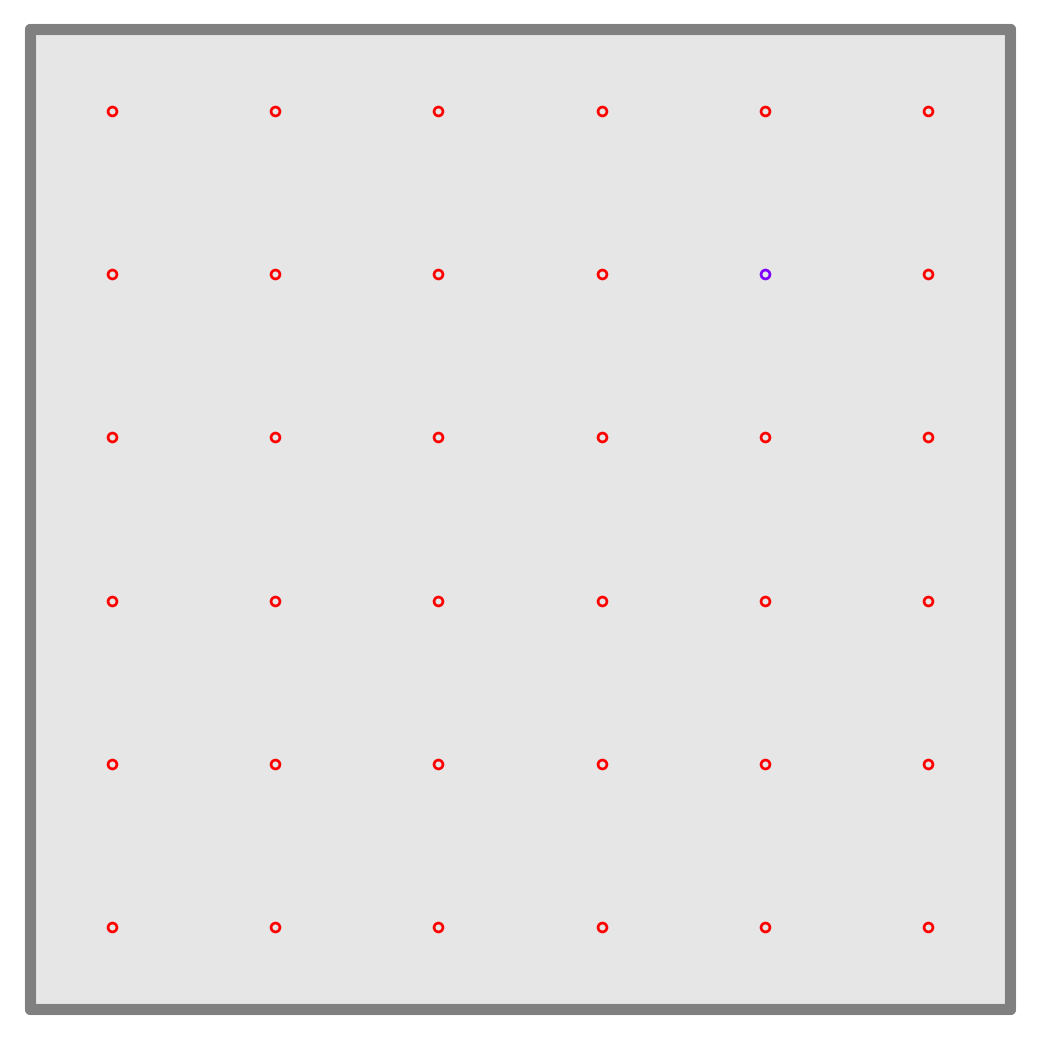

In [13]:
# Create an environment (2m x 2m as in Pfeiffer & Foster)
environment = ratinabox.Environment(params={'aspect': 1.0, 'scale': 2.0})

away_reward_locations = [
    [0.167, 0.167], [0.500, 0.167], [0.833, 0.167], [1.167, 0.167], [1.500, 0.167], [1.833, 0.167],
    [0.167, 0.500], [0.500, 0.500], [0.833, 0.500], [1.167, 0.500], [1.500, 0.500], [1.833, 0.500],
    [0.167, 0.833], [0.500, 0.833], [0.833, 0.833], [1.167, 0.833], [1.500, 0.833], [1.833, 0.833],
    [0.167, 1.167], [0.500, 1.167], [0.833, 1.167], [1.167, 1.167], [1.500, 1.167], [1.833, 1.167],
    [0.167, 1.500], [0.500, 1.500], [0.833, 1.500], [1.167, 1.500], [1.833, 1.500],
    [0.167, 1.833], [0.500, 1.833], [0.833, 1.833], [1.167, 1.833], [1.500, 1.833], [1.833, 1.833]
]
home_reward_location = [1.500, 1.500]  #[1.167, 0.833]

for i, reward in enumerate(away_reward_locations):
    environment.add_object(object=reward, type=0)  # Type 0 for away rewards
environment.add_object(object=home_reward_location, type=1)

environment.plot_environment()

100%|██████████| 100000/100000 [00:43<00:00, 2275.24it/s]


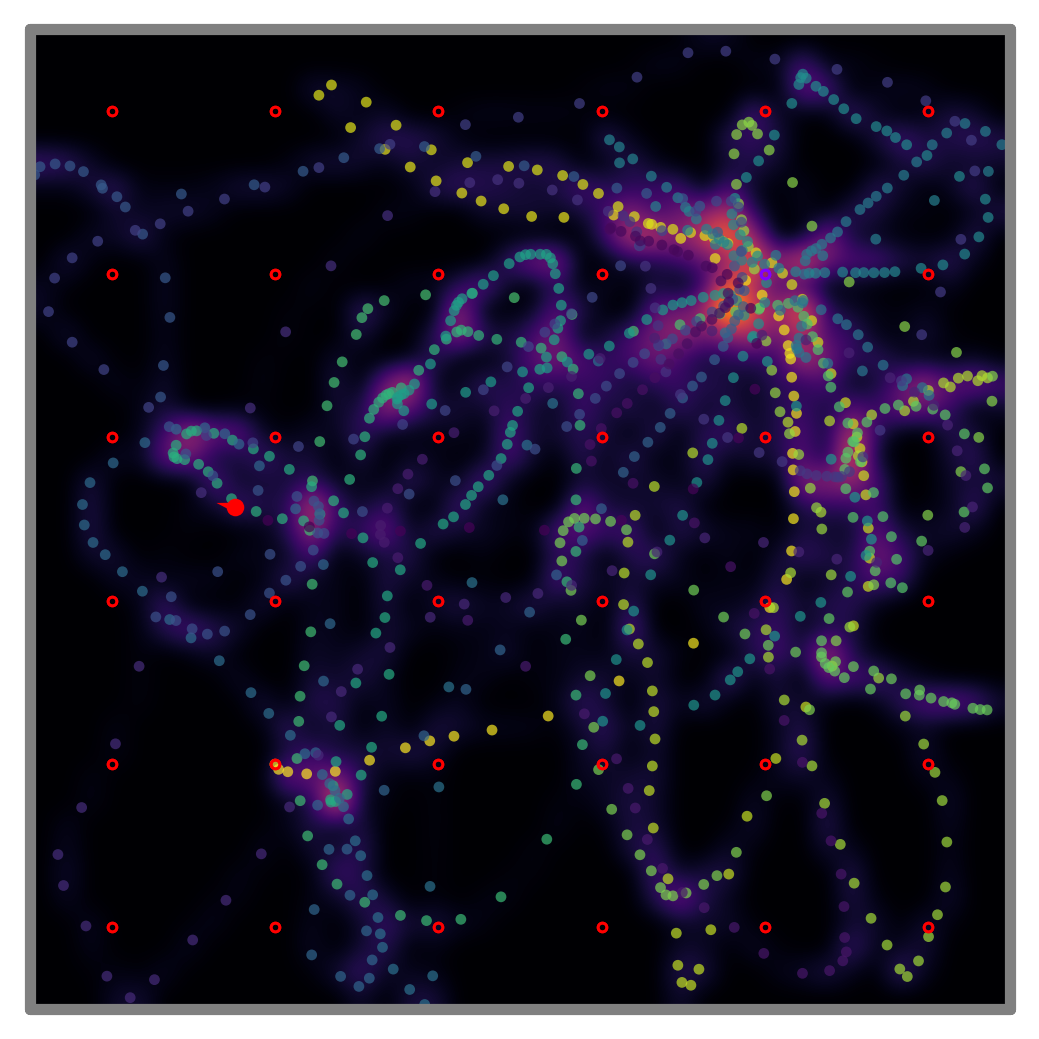

In [14]:
agent = Agent(environment)
agent.pos = np.array([0.5, 0.5])
dt = 1e-3
T = 100
speed = 1.0
agent.speed_mean = speed
proximity_threshold = 0.1
driftratio = 9.0

randomised_away_indices = list(range(len(away_reward_locations)))
randomised_away_rewards = away_reward_locations.copy()
combined = list(zip(randomised_away_indices, randomised_away_rewards))
random.shuffle(combined)
randomised_away_indices, randomised_away_rewards = zip(*combined)
home_reward_index = 35

current_reward_index = 0
current_reward_location = randomised_away_rewards[current_reward_index]
target_is_home = False

active_rewards_over_time = []

for i in tqdm(range(int(T / dt))):
    active_reward = current_reward_location
    active_rewards_over_time.append((i * dt, active_reward))

    reward_vector = current_reward_location - agent.pos
    drift_to_random_strength_ratio = driftratio if target_is_home else driftratio/10.0
    agent.update(dt=dt, drift_velocity=reward_vector, drift_to_random_strength_ratio=drift_to_random_strength_ratio)

    if np.linalg.norm(reward_vector) < proximity_threshold:
        if target_is_home:
            current_reward_index += 1
            if current_reward_index >= len(randomised_away_rewards):
                randomised_away_indices = list(range(len(away_reward_locations)))
                randomised_away_rewards = away_reward_locations.copy()
                combined = list(zip(randomised_away_indices, randomised_away_rewards))
                random.shuffle(combined)
                randomised_away_indices, randomised_away_rewards = zip(*combined)
                current_reward_index = 0
            current_reward_location = randomised_away_rewards[current_reward_index]
        else:
            current_reward_location = home_reward_location
        target_is_home = not target_is_home

    # PCs.update()

positions, times, velocities = agent.history['pos'], np.arange(0, T, dt), agent.history['vel']

np.savez("./RIABTraj/GD_RIAB_trajectory_data_T"+str(T)+
         "_avespeed"+str(speed)+
         "_reward_loc_"+str(home_reward_location[0])+"_"+str(home_reward_location[1])+
         "_driftratio_"+str(driftratio)+".npz", 
         positions=positions, times=times, velocities=velocities)

fig, ax = agent.plot_position_heatmap()
fig, ax = agent.plot_trajectory(t_start=0, t_end=T, fig=fig, ax=ax,color="changing")

In [13]:
def highlight_active_reward(fig, ax, t, active_rewards_over_time, **kwargs):
    active_reward_location = None
    for timestamp, reward in active_rewards_over_time:
        if timestamp <= t < timestamp + dt:
            active_reward_location = reward
            break

    if active_reward_location:
        ax.plot(active_reward_location[0], active_reward_location[1], 'go', markersize=5)  # green dot

    return fig, ax

anim = agent.animate_trajectory(
    t_start=0, 
    t_end=T//2, 
    speed_up=5, 
    fps=10, 
    autosave=True,
    additional_plot_func=highlight_active_reward,
    active_rewards_over_time=active_rewards_over_time
)

Animation saved to /home/zilong/Desktop/GridCellThetaSweeps/figures/20_11_24/trajectory_1050.mp4


## Part 2: generate random foraging trajectories


(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

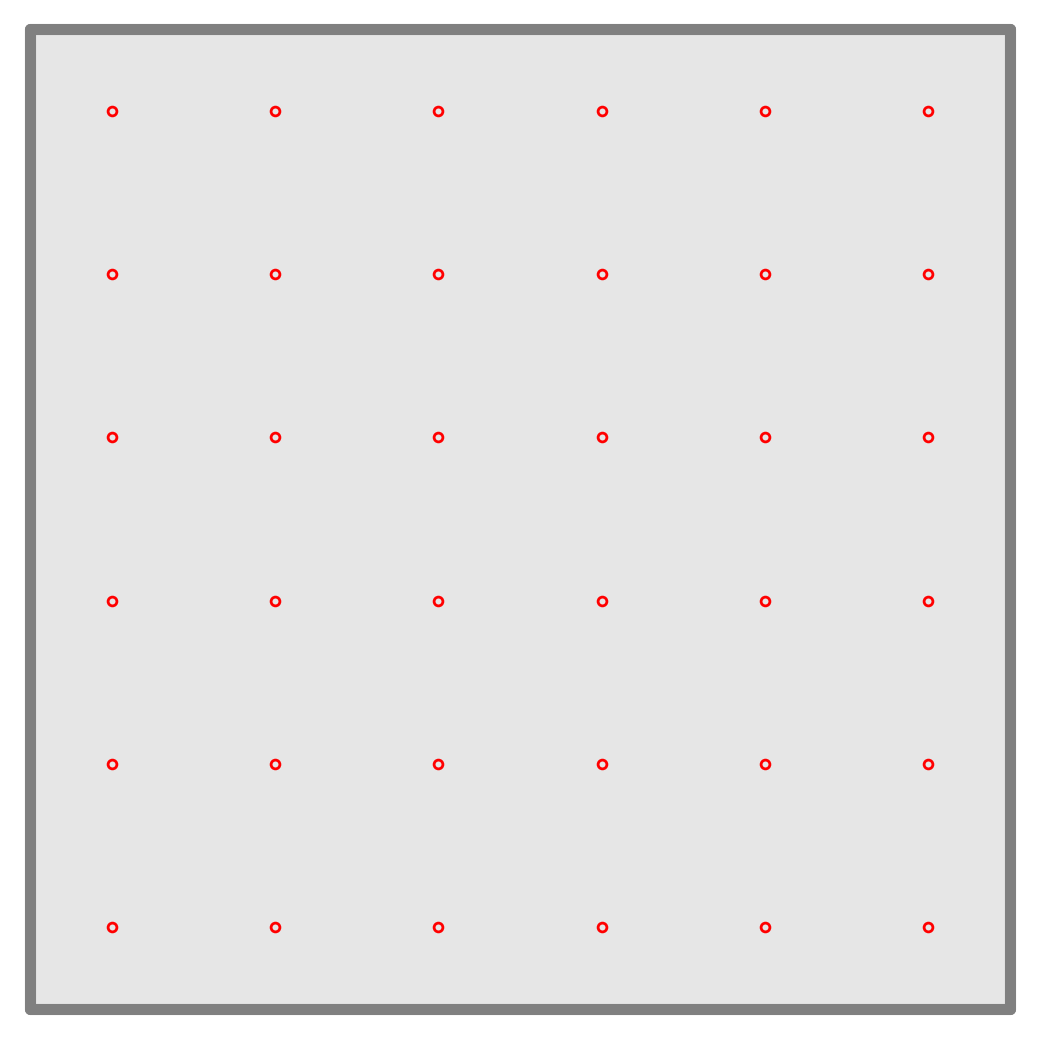

In [2]:
# Create an environment (2m x 2m as in Pfeiffer & Foster)
environment = ratinabox.Environment(params={'aspect': 1.0, 'scale': 2.0})

random_reward_locations = [
    [0.167, 0.167], [0.500, 0.167], [0.833, 0.167], [1.167, 0.167], [1.500, 0.167], [1.833, 0.167],
    [0.167, 0.500], [0.500, 0.500], [0.833, 0.500], [1.167, 0.500], [1.500, 0.500], [1.833, 0.500],
    [0.167, 0.833], [0.500, 0.833], [0.833, 0.833], [1.167, 0.833], [1.500, 0.833], [1.833, 0.833],
    [0.167, 1.167], [0.500, 1.167], [0.833, 1.167], [1.167, 1.167], [1.500, 1.167], [1.833, 1.167],
    [0.167, 1.500], [0.500, 1.500], [0.833, 1.500], [1.167, 1.500], [1.500, 1.500], [1.833, 1.500],
    [0.167, 1.833], [0.500, 1.833], [0.833, 1.833], [1.167, 1.833], [1.500, 1.833], [1.833, 1.833]
]

for i, reward in enumerate(random_reward_locations):
    environment.add_object(object=reward, type=0)  # Type 0 for random rewards

environment.plot_environment()

100%|██████████| 100000/100000 [00:42<00:00, 2357.12it/s]


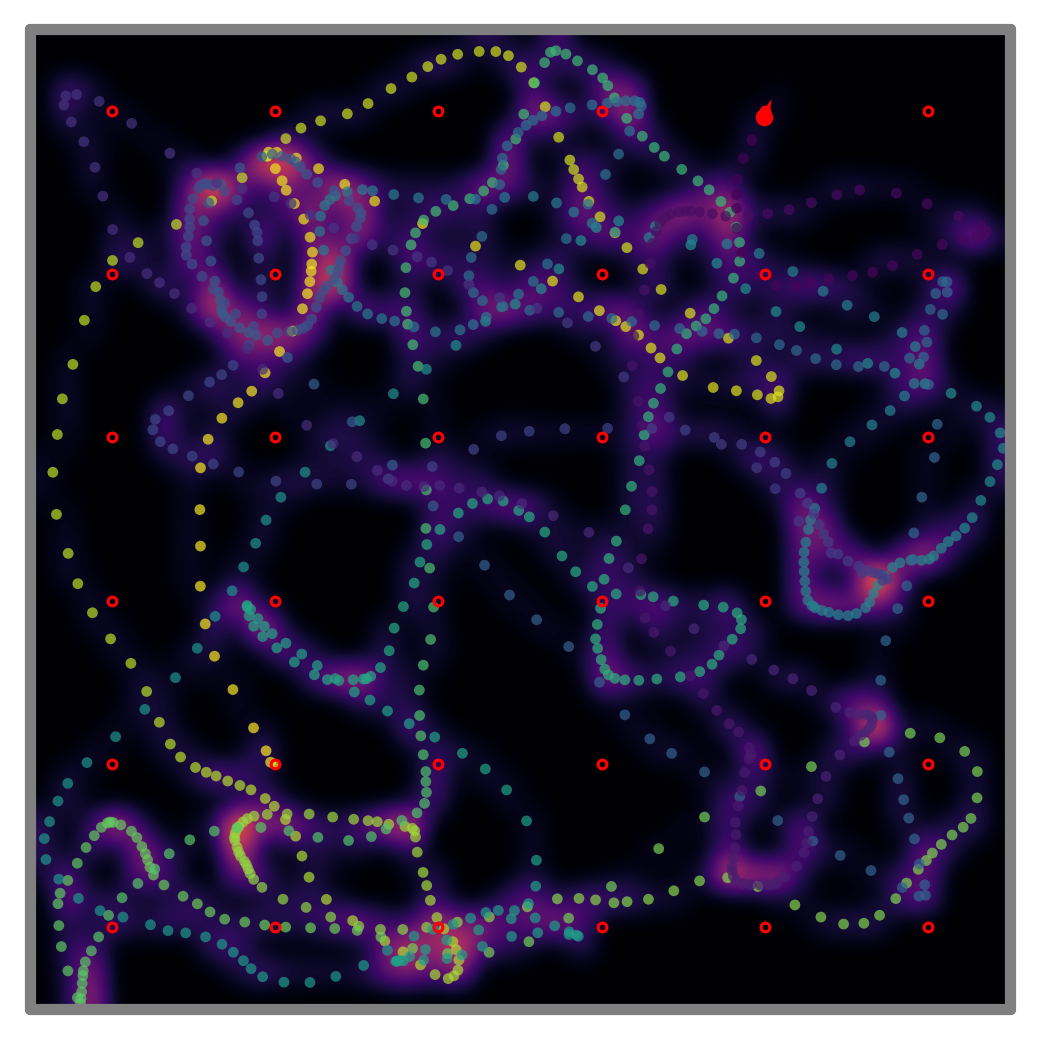

In [4]:
agent = Agent(environment)
agent.pos = np.array([0.5, 0.5])
dt = 1e-3
T = 100
speed = 0.5
agent.speed_mean = speed
proximity_threshold = 0.1
driftratio = 1.0

randomised_indices = list(range(len(random_reward_locations)))
randomised_rewards = random_reward_locations.copy()
combined = list(zip(randomised_indices, randomised_rewards))
random.shuffle(combined)
randomised_indices, randomised_rewards = zip(*combined)

current_reward_index = 0
current_reward_location = randomised_rewards[current_reward_index]

active_rewards_over_time = []

for i in tqdm(range(int(T / dt))):
    active_reward = current_reward_location
    active_rewards_over_time.append((i * dt, active_reward))

    reward_vector = current_reward_location - agent.pos
    drift_to_random_strength_ratio = driftratio
    agent.update(dt=dt, drift_velocity=reward_vector, drift_to_random_strength_ratio=drift_to_random_strength_ratio)

    if np.linalg.norm(reward_vector) < proximity_threshold:
        current_reward_index += 1
        if current_reward_index >= len(randomised_rewards):
            randomised_indices = list(range(len(random_reward_locations)))
            randomised_rewards = random_reward_locations.copy()
            combined = list(zip(randomised_indices, randomised_rewards))
            random.shuffle(combined)
            randomised_indices, randomised_rewards = zip(*combined)
            current_reward_index = 0
        current_reward_location = randomised_rewards[current_reward_index]


positions, times, velocities = agent.history['pos'], np.arange(0, T, dt), agent.history['vel']

np.savez("./RIABTraj/RF_RIAB_trajectory_data_T"+str(T)+
         "_avespeed"+str(speed)+
         "_driftratio_"+str(driftratio)+".npz", 
         positions=positions, times=times, velocities=velocities)

fig, ax = agent.plot_position_heatmap()
fig, ax = agent.plot_trajectory(t_start=0, t_end=T, fig=fig, ax=ax,color="changing")

In [5]:
def highlight_active_reward(fig, ax, t, active_rewards_over_time, **kwargs):
    active_reward_location = None
    for timestamp, reward in active_rewards_over_time:
        if timestamp <= t < timestamp + dt:
            active_reward_location = reward
            break

    if active_reward_location:
        ax.plot(active_reward_location[0], active_reward_location[1], 'go', markersize=5)  # green dot

    return fig, ax

anim = agent.animate_trajectory(
    t_start=0, 
    t_end=T, 
    speed_up=5, 
    fps=10, 
    autosave=True,
    additional_plot_func=highlight_active_reward,
    active_rewards_over_time=active_rewards_over_time
)

Animation saved to /home/zilong/Desktop/GridCellThetaSweeps/figures/18_11_24/trajectory_1625.mp4


## Part 3: generate three reward locations trajectories (Boccaro et al., 2019)

(<Figure size 400x400 with 1 Axes>, <Axes: >)

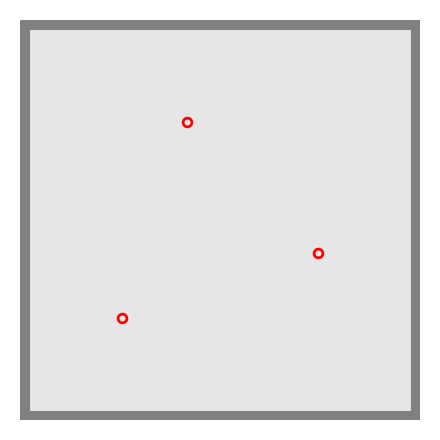

In [10]:
# Create an environment (2m x 2m as in Pfeiffer & Foster)
environment = ratinabox.Environment(params={'aspect': 1.0, 'scale': 2.0})

reward_location_1 = [0.500, 0.500]  #[1.167, 0.833]
reward_location_2 = [1.500, 0.833]
reward_location_3 = [0.833, 1.500]

reward_locations = [reward_location_1, reward_location_2, reward_location_3]

for i, reward in enumerate(reward_locations):
    environment.add_object(object=reward, type=0)  # Type 0 for away rewards

fig, ax = plt.subplots(figsize=(2, 2))
environment.plot_environment(fig=fig, ax=ax)

100%|██████████| 200000/200000 [01:23<00:00, 2395.89it/s]


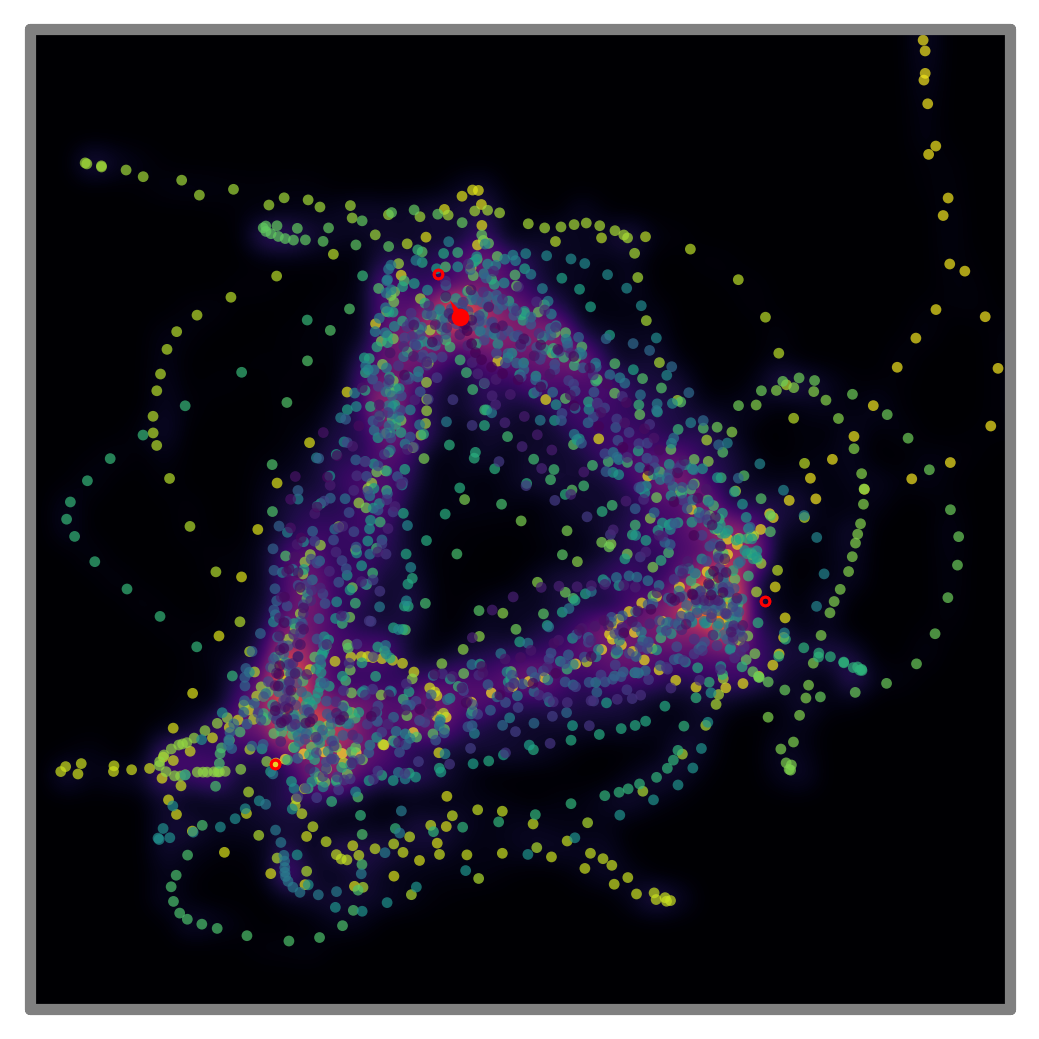

In [17]:
agent = Agent(environment)
agent.pos = np.array([0.5, 0.5])
dt = 1e-3
T = 200
speed = 1.0
agent.speed_mean = speed
proximity_threshold = 0.1
driftratio_start = 1.0
driftratio_end = 5.0
driftratio = driftratio_start

reward_indices = list(range(len(reward_locations)))
combined = list(zip(reward_indices, reward_locations))

current_reward_index = 0
current_reward_location = reward_locations[current_reward_index]

active_rewards_over_time = []

for i in tqdm(range(int(T / dt))):
    #gradually increase drift ratio
    driftratio = driftratio_start + (driftratio_end - driftratio_start) * i / (T / dt)
    active_reward = current_reward_location
    active_rewards_over_time.append((i * dt, active_reward))

    reward_vector = current_reward_location - agent.pos
    drift_to_random_strength_ratio = driftratio
    agent.update(dt=dt, drift_velocity=reward_vector, drift_to_random_strength_ratio=drift_to_random_strength_ratio)

    if np.linalg.norm(reward_vector) < proximity_threshold:
        current_reward_index += 1
        if current_reward_index >= len(reward_locations):
            current_reward_index = 0
        current_reward_location = reward_locations[current_reward_index]

positions, times, velocities = agent.history['pos'], np.arange(0, T, dt), agent.history['vel']

np.savez("./RIABTraj/Triple_RIAB_trajectory_data_T"+str(T)+
         "_avespeed"+str(speed)+
         "_driftratio_"+str(driftratio_start)+".npz", 
         positions=positions, times=times, velocities=velocities, reward_locs = reward_locations)

fig, ax = agent.plot_position_heatmap()
fig, ax = agent.plot_trajectory(t_start=0, t_end=T, fig=fig, ax=ax,color="changing")

## Part 4: generate after-learning trajectories with different reward locations (Boccaro et al., 2019)

(<Figure size 400x400 with 1 Axes>, <Axes: >)

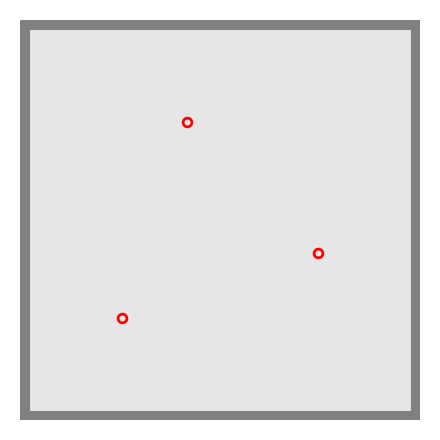

In [18]:
# Create an environment (2m x 2m as in Pfeiffer & Foster)
environment = ratinabox.Environment(params={'aspect': 1.0, 'scale': 2.0})

reward_location_1 = [0.500, 0.500]  #[1.167, 0.833]
reward_location_2 = [1.500, 0.833]
reward_location_3 = [0.833, 1.500]

reward_locations = [reward_location_1, reward_location_2, reward_location_3]

for i, reward in enumerate(reward_locations):
    environment.add_object(object=reward, type=0)  # Type 0 for away rewards

fig, ax = plt.subplots(figsize=(2, 2))
environment.plot_environment(fig=fig, ax=ax)

100%|██████████| 200000/200000 [01:24<00:00, 2362.85it/s]


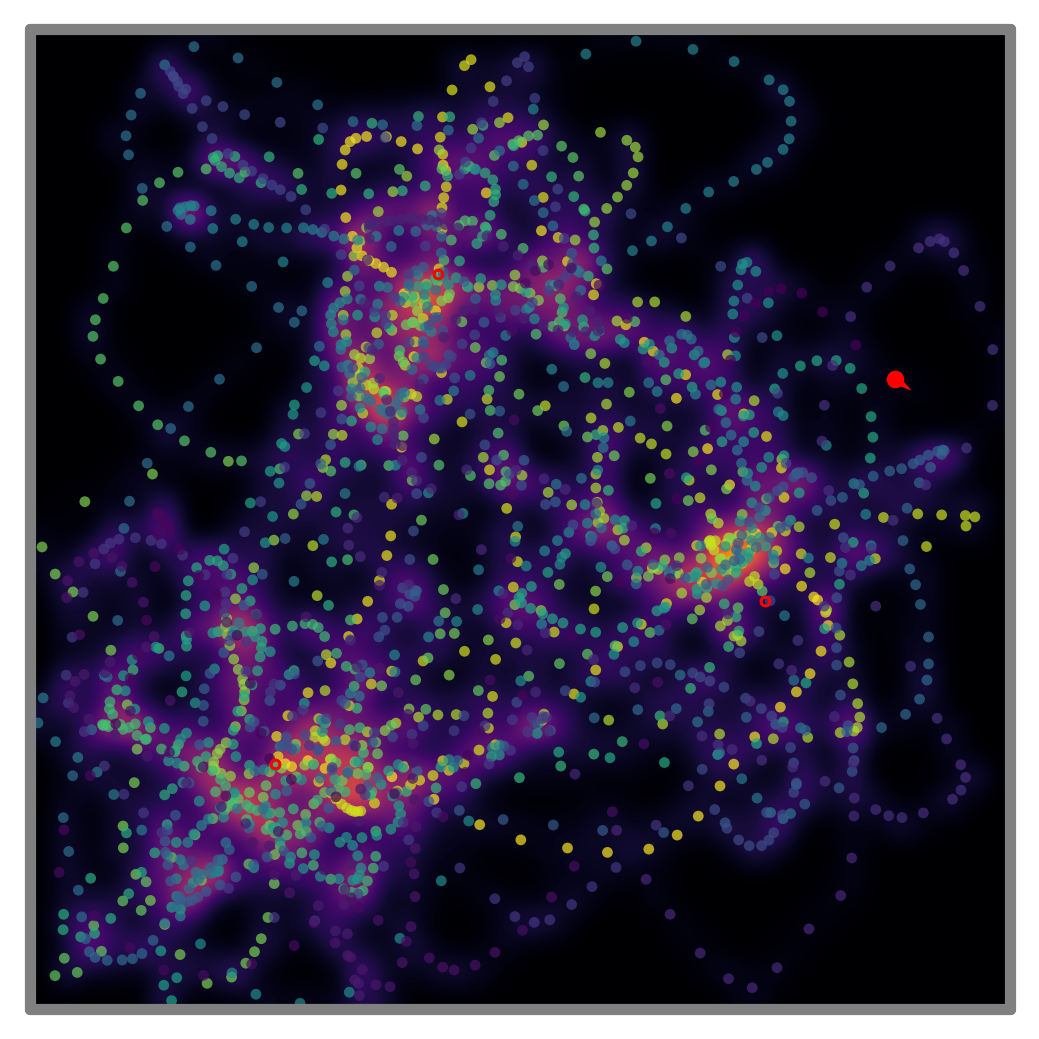

In [19]:
agent = Agent(environment)
agent.pos = np.array([0.5, 0.5])
dt = 1e-3
T = 200
speed = 1.0
agent.speed_mean = speed
proximity_threshold = 0.1
driftratio_start = 2.0
driftratio_end = 1.0
driftratio = driftratio_start

reward_indices = list(range(len(reward_locations)))
combined = list(zip(reward_indices, reward_locations))

current_reward_index = 0
current_reward_location = reward_locations[current_reward_index]

active_rewards_over_time = []

for i in tqdm(range(int(T / dt))):
    #gradually increase drift ratio
    driftratio = driftratio_start + (driftratio_end - driftratio_start) * i / (T / dt)
    active_reward = current_reward_location
    active_rewards_over_time.append((i * dt, active_reward))

    reward_vector = current_reward_location - agent.pos
    drift_to_random_strength_ratio = driftratio
    agent.update(dt=dt, drift_velocity=reward_vector, drift_to_random_strength_ratio=drift_to_random_strength_ratio)

    if np.linalg.norm(reward_vector) < proximity_threshold:
        current_reward_index += 1
        if current_reward_index >= len(reward_locations):
            current_reward_index = 0
        current_reward_location = reward_locations[current_reward_index]

positions, times, velocities = agent.history['pos'], np.arange(0, T, dt), agent.history['vel']

np.savez("./RIABTraj/Triple_afterlearn_RIAB_trajectory_data_T"+str(T)+
         "_avespeed"+str(speed)+
         "_driftratio_"+str(driftratio_start)+".npz", 
         positions=positions, times=times, velocities=velocities, reward_locs = reward_locations)

fig, ax = agent.plot_position_heatmap()
fig, ax = agent.plot_trajectory(t_start=0, t_end=T, fig=fig, ax=ax,color="changing")

## For Changmin's project

In [ ]:
import ratinabox
import random
from tqdm import tqdm

# Create an environment (2m x 2m as in Pfeiffer & Foster)
environment = ratinabox.Environment(params={'aspect': 1.0, 'scale': 1.0})

# away_reward_locations = [
#     [0.1, 0.1], [0.2, 0.2], [0.3, 0.3], [0.4, 0.4], [1.500, 0.167], [1.833, 0.167],
#     [0.167, 0.500], [0.500, 0.500], [0.833, 0.500], [1.167, 0.500], [1.500, 0.500], [1.833, 0.500],
#     [0.167, 0.833], [0.500, 0.833], [0.833, 0.833], [1.167, 0.833], [1.500, 0.833], [1.833, 0.833],
#     [0.167, 1.167], [0.500, 1.167], [0.833, 1.167], [1.167, 1.167], [1.500, 1.167], [1.833, 1.167],
#     [0.167, 1.500], [0.500, 1.500], [0.833, 1.500], [1.167, 1.500], [1.500, 1.500], [1.833, 1.500],
#     [0.167, 1.833], [0.500, 1.833], [0.833, 1.833], [1.167, 1.833], [1.500, 1.833], [1.833, 1.833]
# ]

#away_reward_locations is a list of list, ranging from [0.1, 0.1], [0.1,0.2], .... [0.9,0.9]]
away_reward_locations = []
for i in np.arange(0.05, 1.0, 0.05):
    for j in np.arange(0.05, 1.0, 0.05):
        #if dist between [i,j], [0.25, 0.25] smaller than 0.2, then skip
        if np.linalg.norm(np.array([i, j]) - np.array([0.25, 0.25])) < 0.2:
            continue
        away_reward_locations.append([i, j])
        

home_reward_location = [0.25, 0.25]  #[1.167, 0.833]

for i, reward in enumerate(away_reward_locations):
    environment.add_object(object=reward, type=0)  # Type 0 for away rewards
environment.add_object(object=home_reward_location, type=1)

environment.plot_environment()